# Costa Rican Household Poverty Level Prediction

참고 : https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

이 대회는 개인과 가구를 활용해 가구의 빈곤 수준을 예측하는 기계학습 모델을 개발하는 것이 목표다.

우선, 문제에 대해 소개를 하고, 데이터셋에 대해 EDA(Exploratory Data Analysis)를 수행하고, feature engineering을 하고, 다중 기계학습 모델을 시도해보고, 모델을 선택하고, 모델을 최적화하고, 마지막으로 모델의 결과를 검토하고 결론을 짓는다.

## Problem and Data Explanation

데이터는 train.csv와 test.csv가 주어진다. train 셋은 9557개 행 143개 열로, test 셋은 23856개 행, 142개 열로 이뤄진다. 각 행은 각 개인을 나타내고, 각 열은 개인당 가구 혹은 개인의 고유한 변수를 나타낸다. train 셋은 빈곤수준이 1-4 크기인 추가적인 target 열이 있다. 1값은 가장 심한 빈곤상태다.

다중 분류 기계학습 문제
- Supervised : train 데이터의 레이블과 함께 제공
- Multi-class classification : 레이블이 4가지인 이산형 값

### Objective

가정의 빈곤을 예측하는 것이 목표다. 고유한 변수를 갖는 각 개인에 대한 데이터와 그들의 가구에 대한 정보가 주어진다. 작업할 데이터셋을 생성하기 위해, 각 가구에 대한 개별 데이터의 집계를 해야한다. test 셋의 모든 개인에 대해 예측해야 하지만, "가구의 가장만 점수에 사용된다". 즉, 가구 단위로 빈곤을 예측할 것이다.

참고 : train 데이터에서 모든 가족 구성원은 동일한 레이블을 가져야하지만, 같은 가구의 개인들이 다른 레이블을 갖는다는 오류가 있다. 이 경우, 각 가정의 가장에 대한 레이블을 사용하는데, parentesco1==1.0인 행으로 식별할 수 있다. 

target값은 다음과 같은 빈곤 수준을 나타낸다.
- 1 : 극취약계층
- 2 : 보통취약계층
- 3 : 취약계층
- 4 : 취약계층이 아님

143개 열 중 주의할 것
- id : 각 개인의 고유 식별자. 사용하지 않는 변수다.
- idhogar : 각 가정에 대한 고유 식별자. 변수는 아니지만, 가구의 모든 개인이 동일한 식별자를 가지므로 가구별 개인을 그룹화하는 데 사용한다.
- parentesco1 : 가정의 가장 여부
- target : 가정의 모든 구성원에 대해 동일해야하는 레이블

모델을 만들 때, 가구별 '가장의 빈곤 수준'을 레이블로 가정을 학습시킨다. 원데이터는 가구와 개인이 섞여있으며, 개인 데이터는 각 가구당 집계할 수 있는 방법을 찾아야한다. 일부 개인은 가장이 없는 가정에 속해있어 이 데이터를 학습시킬 수 없다. 이런 데이터 문제는 현실적인 데이터의 아주 전형적인 문제이므로 데이터사이언스 작업에서 마주치는 데이터셋에 대한 준비가 필요하다.

### Metric

궁극적으로 가정의 빈곤 수준을 예측할 수 있는 기계학습 모델을 구축해야한다. 예측 성능은 Macro F1 Score로 평가될 것이다. precision과 recall의 조화 평균인 이항 분류 문제에 대해 표준 F1 score를 사용한다.

다중 클래스 문제는 각 클래스에 F1 score 평균을 낸다. macro F1 score는 레이블 불균형을 고려하지 않고 각 클래스의 F1 score를 평균 낸다. 즉, macro를 사용할 때('가중화된' 점수를 사용할 때) 각 레이블의 발생 횟수는 계산에 포함되지 않는다. 

## Roadmap

최종 목표는 가정의 빈곤 수준을 예측하는 기계학습 모델이다. 우선 문제와 데이터를 이해해야한다. 한 모델을 '최고'라고 선택하기 전, 수많은 모델을 평가하고, 모델을 만든 후 예측을 검토해야한다. 

로드맵
1. 문제 이해
2. EDA (Exploratory Data Analysis)
3. 기계학습을 위한 데이터셋 생성을 위한 Feature engineering
4. 기본 기계학습 모델 몇 가지 비교
5. 더 복잡한 기계학습 모델 사용
6. 선택한 모델 최적화
7. 모델 예측 검토
8. 결론 도출 및 다음 단계 제시

# Getting Started

문제에 대해 잘 알아봤으므로 EDA와 feature engineering으로 넘어간다. EDA는 feature engineering과 모델링에 사용되는 이상치, 추세, 상관관계, 패턴을 탐색한다. 데이터를 (통계량을 통해) 정량적으로 그리고 (그래프를 통해) 시각적으로 조사한다.

일단 데이터의 잠재적으로 유용한 관계를 파악하면, 일부 feature engineering (기계학습 파이프라인의 가장 중요한 부분)을 하고 기본 모델을 구축할 수 있다. 

시작해보자.

#### Imports

In [41]:
# 데이터 조작
import pandas as pd
import numpy as np
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
# plotting 기본값 설정
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data and Look at Summary Information

In [58]:
pd.options.display.max_columns = 150  ### 표 출력시 최대 열 수

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


130개 integer 열, 8개 float(numeric) 열, 5개 object 열이 있다는 것을 알 수 있다. integer열은 (0 또는 1을 갖는) Boolean 변수 혹은 이산형 순서값을 갖는 순서형 변수를 나타낸다. object 열은 기계학습 모델에 직접 입력할 수 없어 문제가 발생한다.

train보다 행이 많은 test 데이터를 살펴보자. target이 없어 열이 하나 적다.

In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### Integer Columns

integer 열의 고유값 분포를 살펴보자. 각 열에 대해 고유한 값의 수를 세 결과를 bar plot에 표시한다.

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

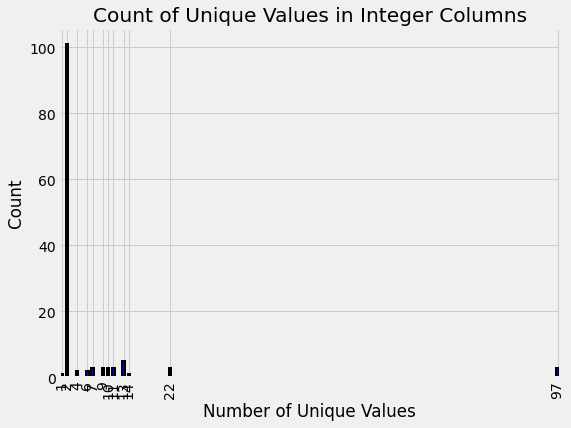

In [61]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize=(8,6), edgecolor='k', linewidth=2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')

고유값이 2개만 있는 열은 Booleans(0 또는 1)을 나타낸다. 이 boolean 정보는 이미 가구 수준에 있다. 예를 들어, refrig 열은 가정에 냉장고가 있는지 여부다. 가구 수준이 나타나는 Boolean에서 변수를 만들 때 이것들을 집계할 필요가 없다. 하지만 개인 수준이 나타나는 Boolean열은 집계해야한다.

#### Float Columns

또 다른 열 유형은 연속형 변수를 나타내는 float이다. 분포도를 통해 모든 float 열의 분포를 보자. key와 value를 지정한 같은 순서로 유지하는 (일반적인 python의 딕셔너리와 달리) OrderedDict를 사용해 빈곤 수준을 색상을 지정해 시각화해보자.

다음 그래프는 target값으로 색상이 지정된 float 열의 분포를 보여준다. 이런 plot을 통해 가구의 빈곤 수준에 따라 변수 분포에 큰 차이가 있는지 확인할 수 있다.

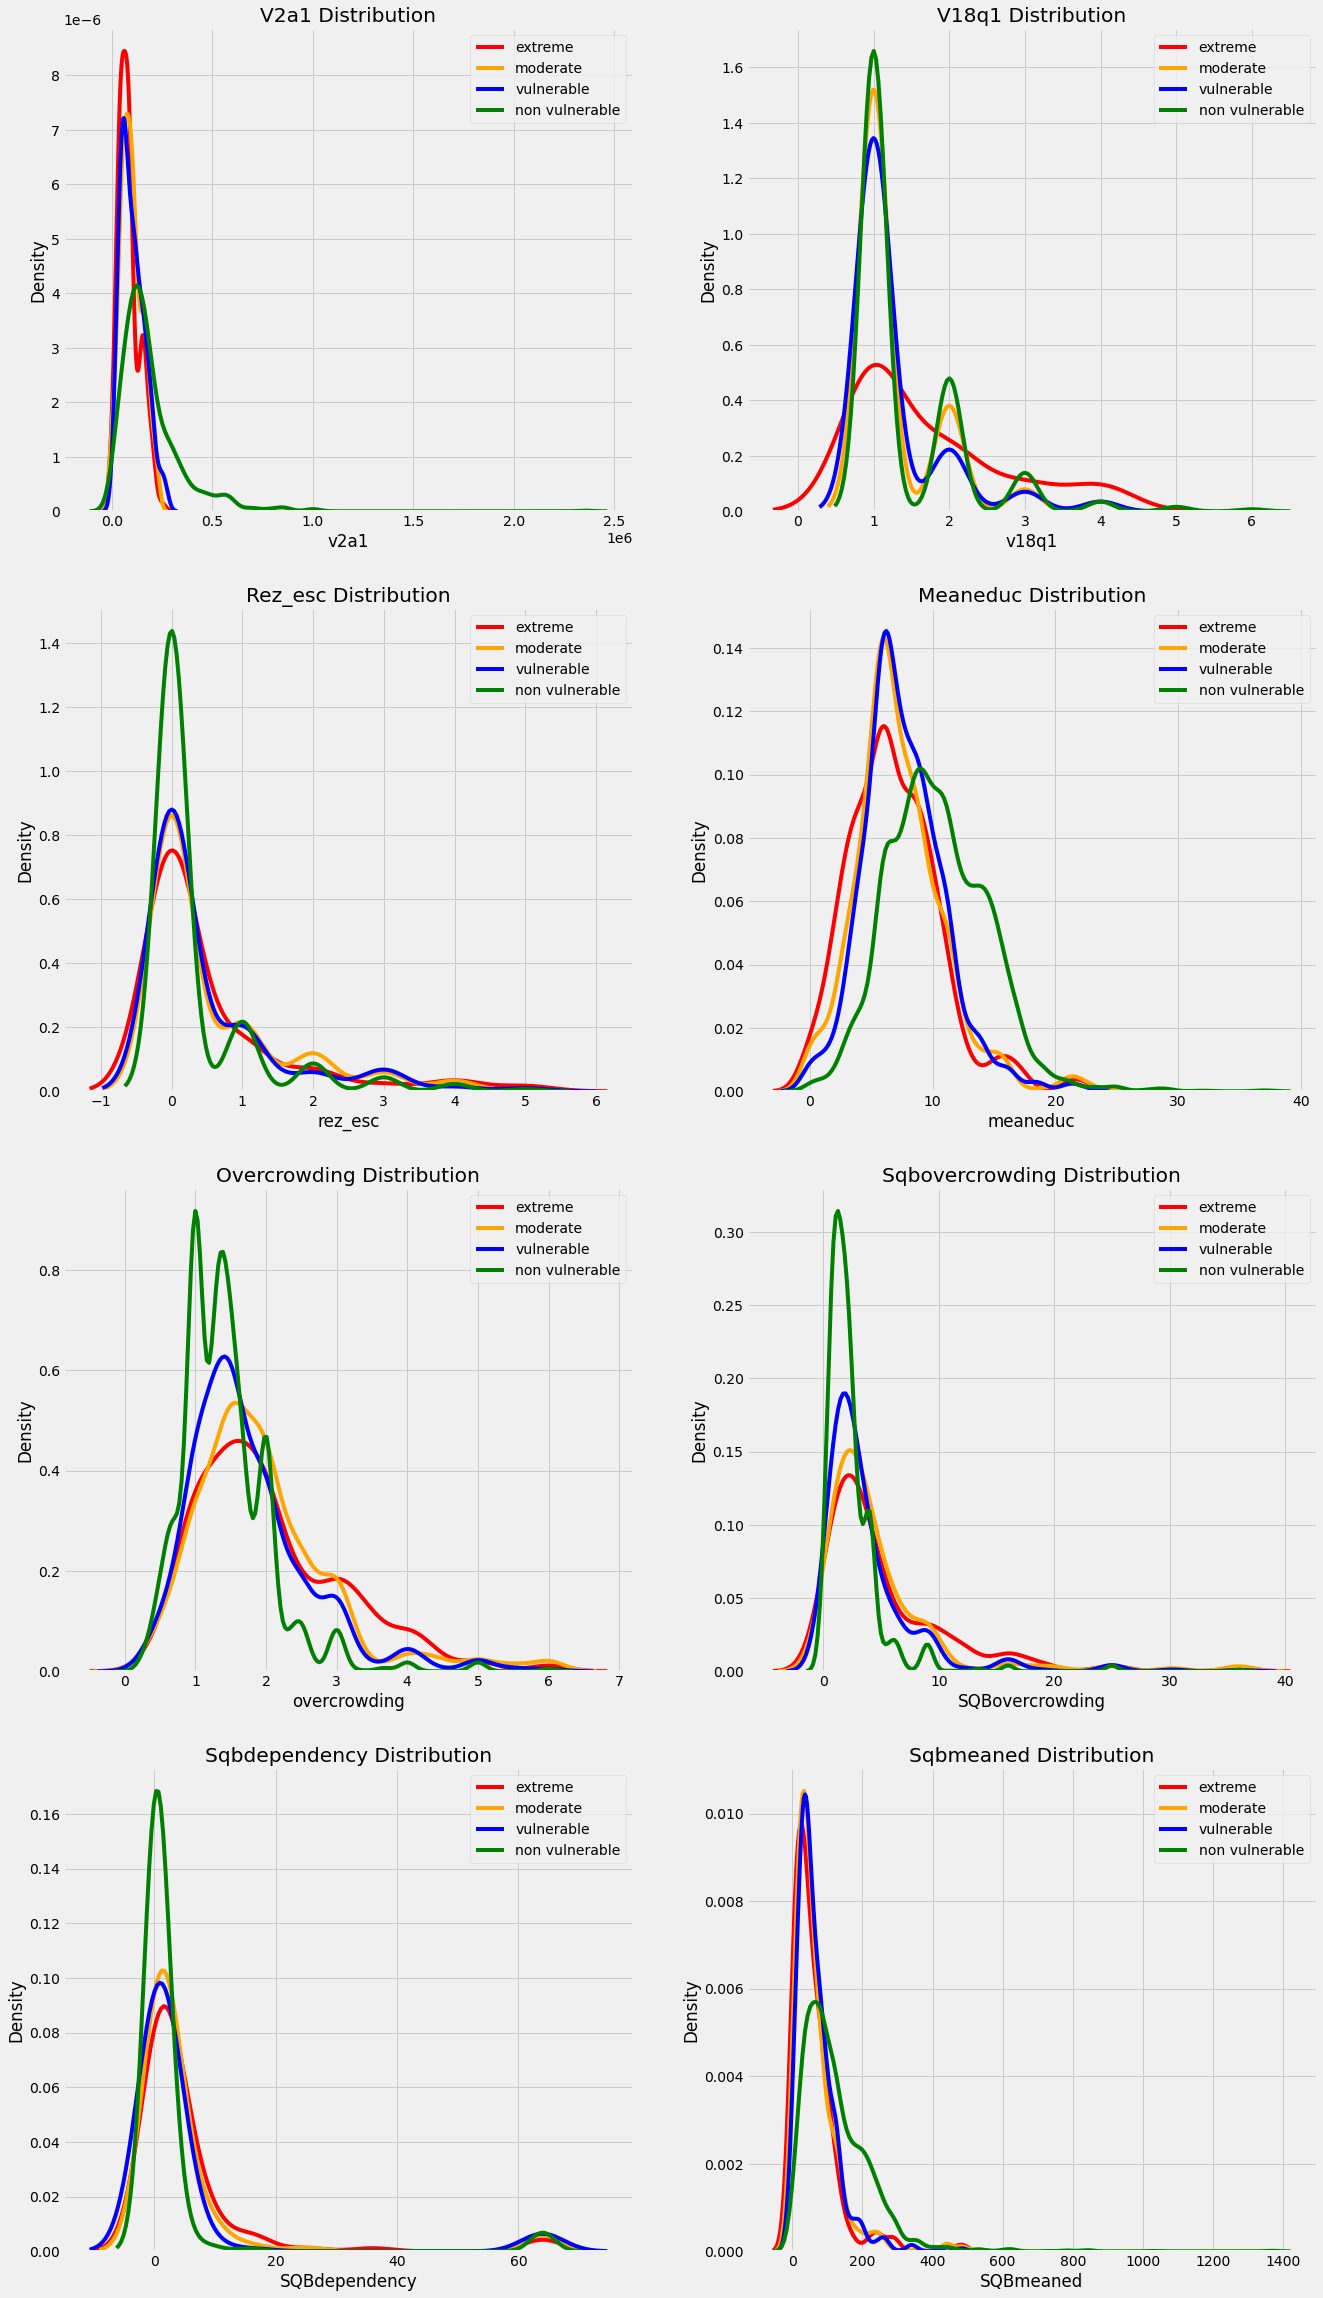

In [62]:
from collections import OrderedDict

plt.figure(figsize=(20,16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1:'red', 2:'orange', 3:'blue', 4:'green'})
poverty_mapping = OrderedDict({1:'extreme', 2:'moderate', 3:'vulnerable', 4:'non vulnerable'})

# float 열 반복
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4,2,i+1)
    # poverty 수준 반복
    for poverty_level, color in colors.items():
        # 개별 선으로 빈곤 수준 시각화
        sns.kdeplot(train.loc[train['Target']==poverty_level,col].dropna(),
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.legend()
        
plt.subplots_adjust(top=2)

나중에 변수와 target값간 상관관계를 계산해 변수간 관계를 살펴볼 것이지만, 위의 그래프를 통해 어느 변수가 모델에 가장 "관련된" 변수인지 파악할 수 있다. 예를 들어, 가정 내 성인의 평균 교육을 나타내는 meaneud 변수는 빈곤 수준과 관련있어 보인다. 즉, 평균 성인 교육이 높을수록 target값이 높다(빈곤이 덜한 수준). 교육의 중요성은 나중에 다시 보자.

#### Object Columns

In [63]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


id와 idhogar의 object 타입은 식별 변수이므로 의미가 있다. 그러나 다른 열은 기계학습을 하기 전 처리해야할 문자열과 숫자의 혼합인 것 같다. 
- dependency : 의존율. (19세 이하, 64세 이상 가구원수) / (19~64세 가구원수)
- edjefe : 남성 가장의 교육년도. 가장의 escolari(교육년도)와 성별의 상호작용에 기반. yes=1, no=0
- edjefa : 여성 가장의 교육년도. 가장의 escolari(교육년도)와 성별의 상호작용에 기반. yes=1, no=0

이 세 변수를 매핑을 사용해 수정하고 float으로 변환할 수 있다.

In [64]:
mapping = {'yes':1, 'no':0}

# train, test에 같은 작업 적용
for df in [train, test]:
    # 값을 옳은 mapping으로 채움
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
    
train[['dependency','edjefa','edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


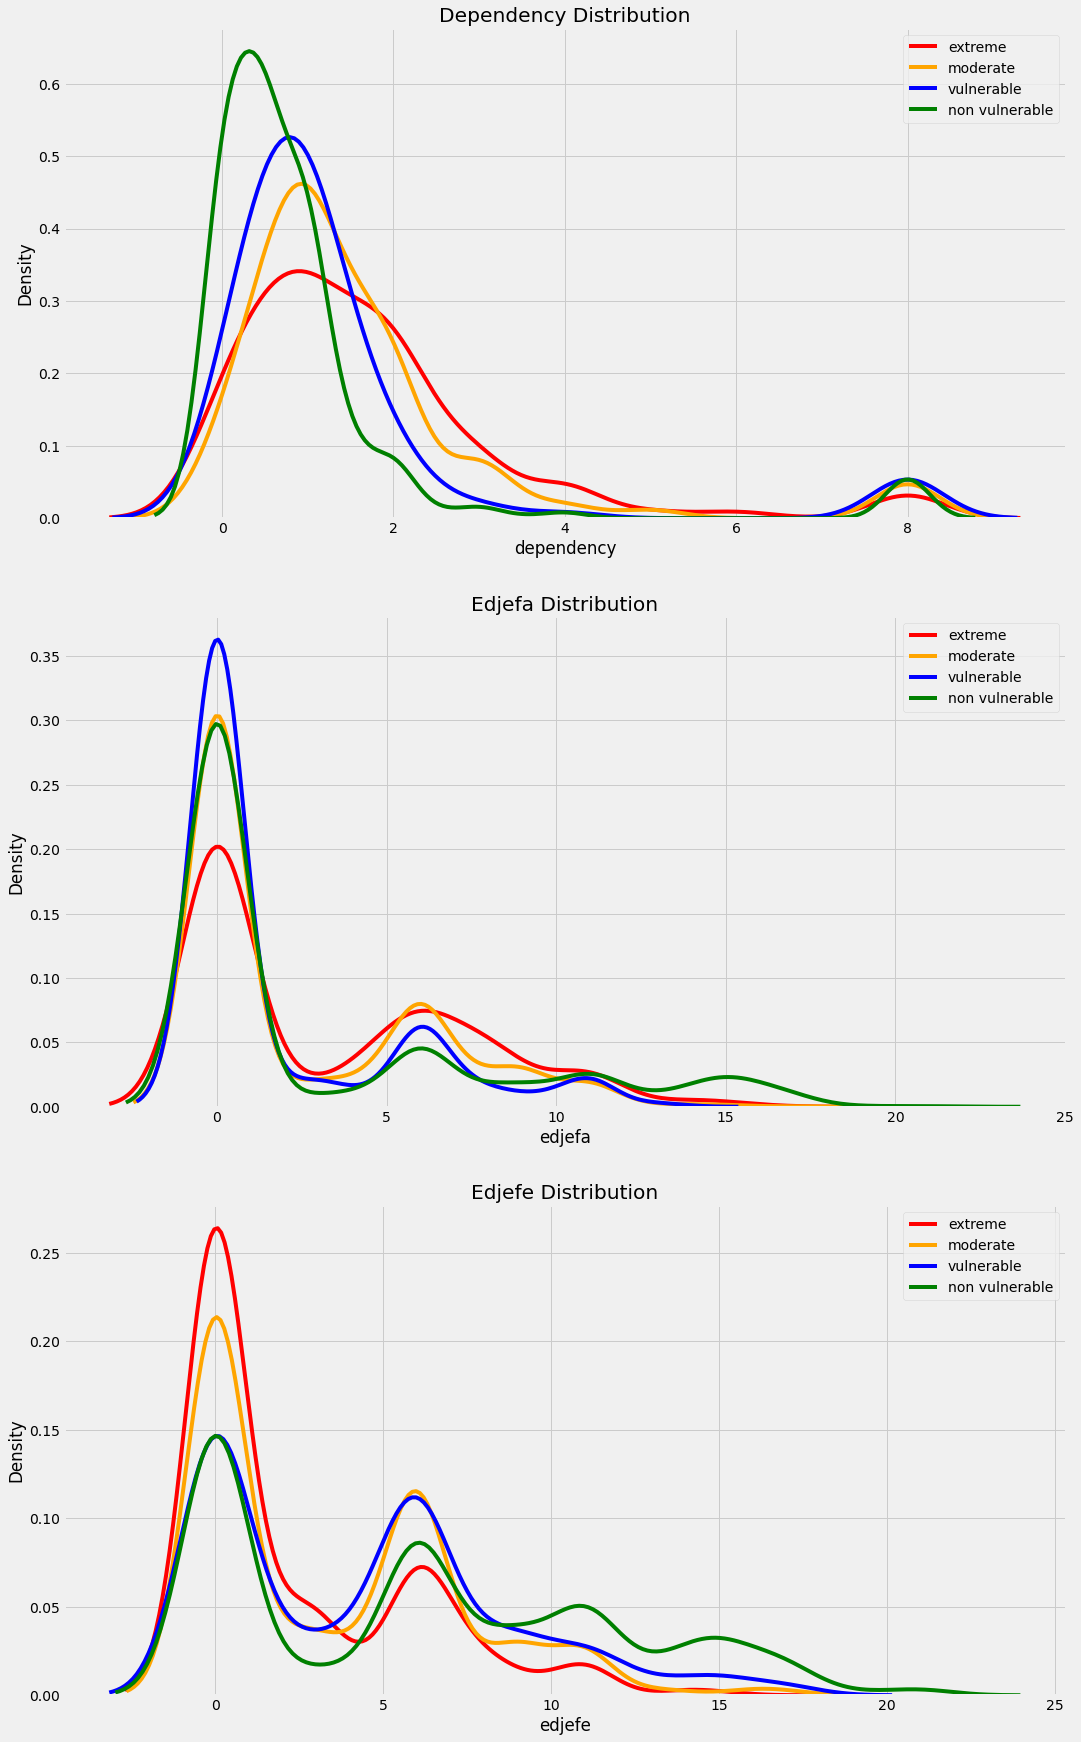

In [70]:
plt.figure(figsize=(16,12))

# float 열 반복
for i, col in enumerate(['dependency','edjefa','edjefe']):
    ax = plt.subplot(3,1,i+1)
    # 빈곤 수준 반복
    for poverty_level, color in colors.items():
        # 개별 선으로 빈곤 수준 시각화
        sns.kdeplot(train.loc[train['Target']==poverty_level,col].dropna(),
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.legend()

plt.subplots_adjust(top=2)

이제 위의 변수들이 숫자로 올바르게 나타나고 기계학습 모델에 입력할 수 있게 됐다.

위와 같은 작업을 더 쉽게 하기 위해, train, test 데이터프레임을 join한다. 이는, 두 데이터프레임에 동일한 작업을 적용해 같은 변수를 사용할 수 있어야하므로 feature engineering을 할 때 중요하다. 나중에 Target에 따라 데이터셋을 분리할 수 있다.

In [66]:
# test에 null값인 Target 열 추가
test['Target'] = np.nan
data = train.append(test, ignore_index=True)

## Exploring Label Distribution

레이블의 분포 통해 문제가 얼마나 불균형한지 알 수 있다. 4가지 빈곤 수준을 나타내는 integer 수준이 4개 있다. 올바른 레이블을 보기 위해, 각 가정의 옳은 레이블인 가장이 해당되는 parentesco1==1인 열만 하위 집합으로 취한다. 

아래 bar plot은 train 레이블의 분포를 보인다(test 레이블이 없으므로).

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

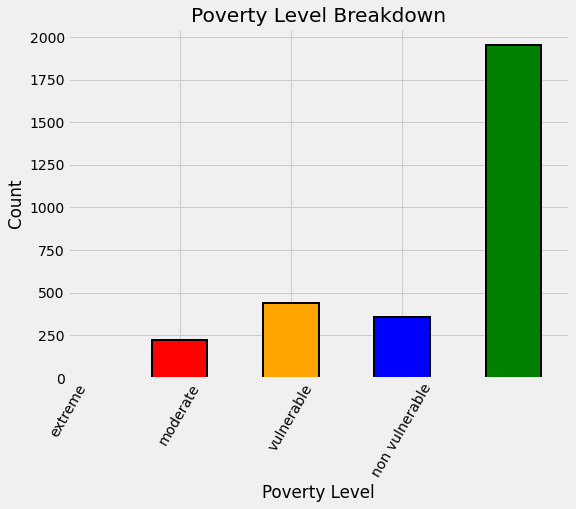

In [72]:
# 가장
heads = data.loc[data['parentesco1']==1].copy()
# trian 의 레이블  ### Target이 결측이 아니고 가장(parentesco==1)인 Target, idhogar값
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1']==1), ['Target','idhogar']]
# target값 count
label_counts = train_labels['Target'].value_counts().sort_index()

# 각 레이블의 bar plot
label_counts.plot.bar(figsize=(8,6),color=colors.values(),edgecolor='k',linewidth=2)
plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.xticks([x-1 for x in poverty_mapping.keys()], list(poverty_mapping.values()), rotation=60)
plt.title('Poverty Level Breakdown')

label_counts

불균형 클래스 문제를 다루고 있다(가중치 F1 대신 macro F1 score를 선택한 이유와 관련있다). 비취약계층으로 분류되는 가구가 다른 범주보다 훨씬 많다. 극취약계층은 가장 적다.

불균형 분류 문제의 한 가지 문제는 기계학습 모델이 훨씬 적은 클래스를 예측하기 어려울 수 있다는 것이다. 클래스 불균형 문제를 해결하는 방법 중 하나는 오버샘플링이다.

## Addressing Wrong Labels

실제 데이터셋처럼 Costa Rican Poverty 데이터도 몇가지 문제가 있다. 이상치나 오류를 수정해야할 수 있다. 이건 인간의 입력 오류, 측정 오류, 옳은 값이지만 눈에 띄는 극단치일 수 있다. 여기선 동일한 가구의 개인별 빈곤 수준이 다르기 때문에 레이블의 일부는 정확하지 않다. 따라서 가장을 옳은 레이블로 보자.

### Identify Errors

우선 오류를 찾아야한다. 다른 레이블을 가진 가족 구성원이 있는 가구를 찾기 위해, 가구별로 데이터를 그룹화하고 Target의 고유값이 하나만 있는지 확인해본다.

In [73]:
# 가구별 그룹화 및 고유값 수 표시
all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)
# target이 동일하지 않은 가구
not_equal = all_equal[all_equal != True]

print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


예시를 하나 보자.

In [74]:
train[train['idhogar']==not_equal.index[0]][['idhogar','parentesco1','Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


주최측에서 올바른 레이블은 가장(parentesco1==1)의 레이블이라고 한다. 이 가정의 경우, 모든 구성원의 올바른 레이블은 3이다. 이 가정의 모든 구성원에게 올바른 빈곤수준을 재할당해 옳게 바꿀 수 있다. 

### Families without Heads of Household

가장이 없는 가정이 있다면, 가구원의 레이블이 다를 경우 불일치를 어떻게 해결하는지 알아보자.

In [75]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()  ### 가구별 총 가장 수
# 가장 없는 가정
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader==0].index),:] ### 총 가장 수가 0인 가정

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [77]:
# 레이블이 다른 가장 없는 가정
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)
print('{} Households with no head have different lables.'.format(sum(households_no_head_equal==False)))

0 Households with no head have different lables.


다행히 가장이 없고 구성원의 레이블이 다른 값인 가정을 고려할 필요가 없다. 주최측에 따르면 가장이 없는 가정은 참인 레이블이 없다. 따라서 실제로 학습하는 데 가장 없는 가정은 사용하지 않는다.

### Correct Errors

이제 가장이 있는 가정과 구성원의 빈곤 수준이 다른 레이블을 수정한다.

In [79]:
# 각 가정 반복
for household in not_equal.index:  ### 빈곤수준이 다른 가정 반복
    # 옳은 레이블 찾기 (가장)
    true_target = int(train[(train['idhogar']==household) & (train['parentesco1']==1.0)]['Target'])
    # 가정의 모든 구성원에게 옳은 레이블 부여
    train.loc[train['idhogar']==household,'Target'] = true_target
    
# 가구별 그룹화 및 고유값 표시
all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)
# target이 동일하지 않은 가정
not_equal = all_equal[all_equal != True]

print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


가장의 레이블만 사용할 예정이므로 이 단계가 꼭 필요한 건 아니지만 실제 발생할 수 있는 데이터 오류를 수정하는 것을 보여준다.

## Missing Variables